In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.1 MB/s eta 0:00:00


Searching for TCI (True Color Image) JP2 files...
SUCCESS! Found 50 TCI JP2 images.
Image 1 (Src): /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20180820T083601_N0206_R064_T36UXA_20180820T105651/S2A_MSIL1C_20180820T083601_N0206_R064_T36UXA_20180820T105651.SAFE/GRANULE/L1C_T36UXA_A016506_20180820T083816/IMG_DATA/T36UXA_20180820T083601_TCI.jp2
Image 2 (Ref): /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20180810T083601_N0206_R064_T36UXA_20180810T124435/S2A_MSIL1C_20180810T083601_N0206_R064_T36UXA_20180810T124435.SAFE/GRANULE/L1C_T36UXA_A016363_20180810T084438/IMG_DATA/T36UXA_20180810T083601_TCI.jp2
Using device: cuda
Loaded SuperPoint model
SuperPoint model successfully loaded.
Loaded SuperGlue model ("outdoor" weights)
SuperGlue model successfully loaded.
GeoJSON labels /kaggle/input/deforestation-in-ukraine/deforestation_labels.geojson successfully loaded.
Deforestation mask applied: SuperPoint will search for features outside these zones.
Running SuperPoint and SuperGlue...
Ma

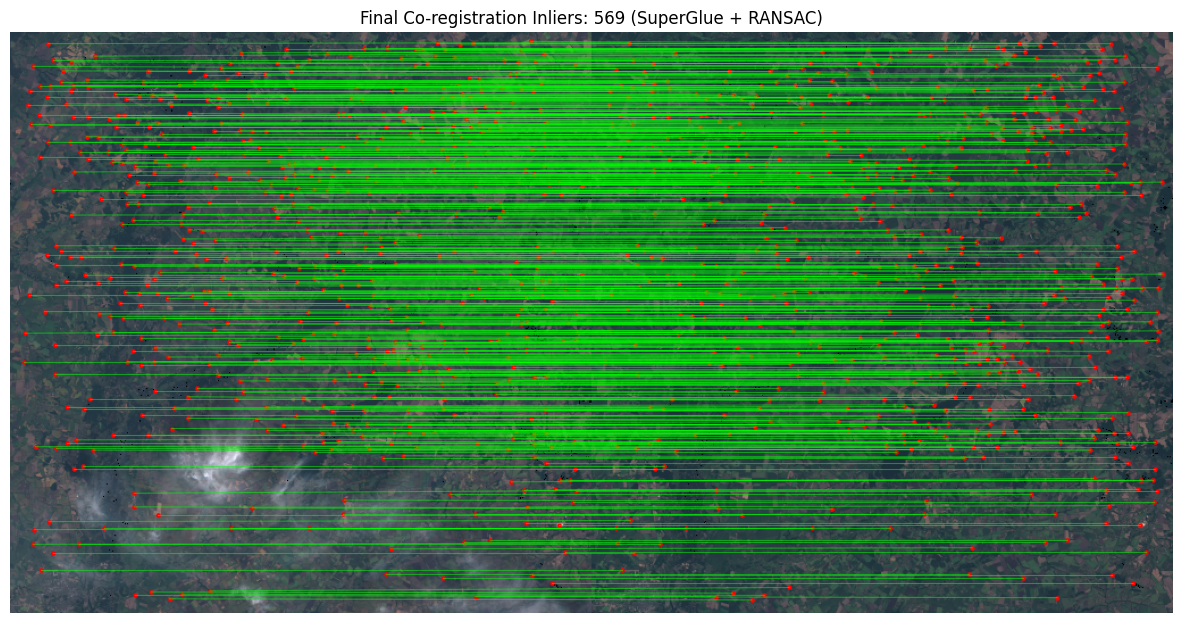

Final visualization saved to file: /kaggle/working/final_superglue_matches.png


In [ ]:
# ======================
# Imports
# ======================
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

# GIS/GeoPandas imports added
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union # Replacement for deprecated cascaded_union

# Add path to SuperGlue repository
# This path should be relevant in your Kaggle environment
sys.path.append("/kaggle/input/supergluepretrainednetwork/pytorch/default/1")

try:
    from models.superpoint import SuperPoint
    from models.superglue import SuperGlue
except ImportError:
    print("Error: Could not import SuperPoint/SuperGlue. Check the path in sys.path.append()")
    # Define dummy classes to prevent code from crashing, but also not working
    class SuperPoint(torch.nn.Module):
        def __init__(self, config={}): pass
        def forward(self, data): raise ImportError("SuperPoint not loaded")

    class SuperGlue(torch.nn.Module):
        def __init__(self, config={}): pass
        def forward(self, data): raise ImportError("SuperGlue not loaded")

# ======================
# Dataset Settings
# ======================
BASE_DATASET_PATH = "/kaggle/input/deforestation-in-ukraine/"
LABELS_PATH = os.path.join(BASE_DATASET_PATH, 'deforestation_labels.geojson')

# --- ENHANCED JP2 FILE SEARCH ---
# Search for TCI (True Color Image) files located in IMG_DATA folders
print("Searching for TCI (True Color Image) JP2 files...")
all_file_paths = sorted(glob.glob(os.path.join(BASE_DATASET_PATH, "**", "IMG_DATA", "*TCI.jp2"), recursive=True))

# --- Found Files Check ---
if len(all_file_paths) < 2:
    raise RuntimeError(f"No TCI.jp2 files found for matching. Found: {len(all_file_paths)}. Check the folder structure in '{BASE_DATASET_PATH}'.")
else:
    # Take two images for the example (earliest and latest)
    path1 = all_file_paths[13]
    path2 = all_file_paths[12]

    print(f"SUCCESS! Found {len(all_file_paths)} TCI JP2 images.")
    print(f"Image 1 (Src): {path1}")
    print(f"Image 2 (Ref): {path2}")

# ======================
# Image and Metadata Loading and Transformation


# --- GIS HELPER FUNCTION ---
def poly_from_utm(polygon, transform):
    """Transforms a polygon from world coordinates to image pixel coordinates."""
    # Use unary_union to handle MultiPolygon or a single Polygon
    poly = unary_union(polygon)

    # --- TypeError FIX ---
    # Force the use of only 2D coordinates (x, y), ignoring Z
    # Check if exterior even exists
    if poly.exterior is None:
        return Polygon() # Return an empty polygon

    poly_pts = [~transform * (pt[0], pt[1]) for pt in poly.exterior.coords]

    return Polygon(poly_pts)

def create_deforestation_mask(df_labels, raster_meta):
    """
    Creates a binary mask based on GeoJSON polygons and raster metadata.
    """
    df = df_labels.copy()

    # 1. CRS Transformation (GeoJSON is usually in EPSG:4326)
    # --- FutureWarning FIX ---
    df.crs = 'epsg:4326' # Removed deprecated {'init':...}
    try:
        # Ensure raster CRS is valid
        if raster_meta['crs']:
            df = df.to_crs(raster_meta['crs'])
        else:
            print("WARNING: Raster CRS is not defined. Skipping transformation.")
    except Exception as e:
        print(f"WARNING: CRS transformation error: {e}. Using original CRS.")
        pass

    poly_shp = []
    im_size = (raster_meta['height'], raster_meta['width'])

    for _, row in df.iterrows():
        geometry = row['geometry']
        if geometry is None or geometry.is_empty:
            continue

        if geometry.geom_type == 'Polygon':
            poly_shp.append(poly_from_utm(geometry, raster_meta['transform']))
        elif geometry.geom_type == 'MultiPolygon':
            # Handle MultiPolygon
            for p in geometry.geoms:
                if p is not None and not p.is_empty:
                    poly_shp.append(poly_from_utm(p, raster_meta['transform']))

    # 2. Rasterization of polygons
    if not poly_shp:
        print("WARNING: No valid polygons found for rasterization. Returning empty mask.")
        mask = np.zeros(im_size, dtype=np.uint8)
    else:
        mask = rasterize(shapes=poly_shp, out_shape=im_size, dtype=np.uint8)

    # 3. Invert to focus on STABLE zones (outside deforestation)
    stable_mask = 1 - mask

    return stable_mask


def load_sentinel_with_meta(path, max_dim=512):
    """
    Loads TCI (RGB) JP2, metadata, scales, and converts to monochrome.
    """
    driver = 'JP2OpenJPEG'
    try:
        with rasterio.open(path, "r", driver=driver) as src:
            # TCI is a 3-channel (RGB) 8-bit image
            img_rgb = src.read([1, 2, 3]) # Read (R, G, B)
            meta = src.meta
    except rasterio.errors.RasterioIOError as e:
        print(f"ERROR: Could not read file {path} with driver {driver}. Error: {e}")
        return None, None, None

    if img_rgb is None:
        raise ValueError(f"Failed to open image: {path}")

    # Convert from (C, H, W) to (H, W, C)
    img_rgb = reshape_as_image(img_rgb)

    # Scale
    h, w = img_rgb.shape[:2]
    scale = max_dim / max(h, w)
    new_size = (int(w * scale), int(h * scale))

    img_rgb_resized = cv2.resize(img_rgb, new_size, interpolation=cv2.INTER_AREA)

    # Convert to monochrome for SuperPoint
    img_mono = cv2.cvtColor(img_rgb_resized, cv2.COLOR_RGB2GRAY)

    # Return monochrome (for DL), RGB (for visualization) and meta (for GIS)
    return img_mono, img_rgb_resized, meta


# ======================
# Convert to Tensor for SuperPoint

def frame2tensor(img_mono, device):
    """Converts an 8-bit monochrome image to a tensor [1,1,H,W]"""
    img = img_mono.astype('float32') / 255.0
    tensor = torch.from_numpy(img)[None, None, :, :]
    return tensor.to(device)


# ======================
# Create Models and Load Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# SuperPoint - needed for keypoint detection
SP_CONFIG = {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024}
SP_WEIGHTS_PATH = "/kaggle/input/superpoint-pretrained-network/SuperPointPretrainedNetwork-master/superpoint_v1.pth"
superpoint = SuperPoint(SP_CONFIG)
superpoint.load_state_dict(torch.load(SP_WEIGHTS_PATH))
superpoint.to(device).eval()
print("SuperPoint model successfully loaded.")

# SuperGlue - needed for matching
SG_CONFIG = {'weights': 'outdoor'}  # 'outdoor'
SG_WEIGHTS_PATH = "/kaggle/input/supergluepretrainednetwork/pytorch/default/1/models/weights/superglue_outdoor.pth"
superglue = SuperGlue(SG_CONFIG)
superglue.load_state_dict(torch.load(SG_WEIGHTS_PATH))
superglue.to(device).eval()
print("SuperGlue model successfully loaded.")

# Load and prepare labels (once)
try:
    df_labels = gpd.read_file(LABELS_PATH)
    print(f"GeoJSON labels {LABELS_PATH} successfully loaded.")
except Exception as e:
    print(f"ERROR: Failed to load GeoJSON labels: {e}")
    df_labels = gpd.GeoDataFrame() # Create an empty DataFrame to prevent code crash


# ======================
#  Select Image Pair for Example and MASK

img1_mono_raw, img1_vis_raw, meta1 = load_sentinel_with_meta(path1)
img2_mono_raw, img2_vis_raw, meta2 = load_sentinel_with_meta(path2)

if img1_mono_raw is None or img2_mono_raw is None:
    raise RuntimeError("Failed to load one or both images. Check paths and file integrity.")

# --- APPLY MASKING ---
if not df_labels.empty:
    mask1_stable = create_deforestation_mask(df_labels, meta1)
    mask2_stable = create_deforestation_mask(df_labels, meta2)

    H, W = img1_mono_raw.shape[:2]
    mask1_resized = cv2.resize(mask1_stable, (W, H), interpolation=cv2.INTER_NEAREST)
    mask2_resized = cv2.resize(mask2_stable, (W, H), interpolation=cv2.INTER_NEAREST)

    # Apply mask to monochrome versions for DL
    img1_mono = img1_mono_raw * mask1_resized
    img2_mono = img2_mono_raw * mask2_resized

    # Apply mask to RGB versions for visualization
    img1_vis = img1_vis_raw * np.expand_dims(mask1_resized, axis=-1)
    img2_vis = img2_vis_raw * np.expand_dims(mask2_resized, axis=-1)

    print("Deforestation mask applied: SuperPoint will search for features outside these zones.")
else:
    print("WARNING: GeoJSON labels not loaded. Skipping masking.")
    img1_mono = img1_mono_raw
    img2_mono = img2_mono_raw
    img1_vis = img1_vis_raw
    img2_vis = img2_vis_raw


tensor1 = frame2tensor(img1_mono, device)
tensor2 = frame2tensor(img2_mono, device)

# ======================
#Run through SuperPoint and SuperGlue

print("Running SuperPoint and SuperGlue...")
with torch.no_grad():
    # SuperPoint
    pred1 = superpoint({'image': tensor1})
    pred2 = superpoint({'image': tensor2})

    # Extract keypoint tensors for SuperGlue
    kpts0_tensor = pred1['keypoints'][0] if len(pred1['keypoints']) > 0 else torch.empty(0, 2, device=device)
    kpts1_tensor = pred2['keypoints'][0] if len(pred2['keypoints']) > 0 else torch.empty(0, 2, device=device)

    # SuperPoint also returns 'scores' as a list, extract the tensor
    scores0_tensor = pred1['scores'][0] if len(pred1['scores']) > 0 else torch.empty(0, device=device)
    scores1_tensor = pred2['scores'][0] if len(pred2['scores']) > 0 else torch.empty(0, device=device)

    # SuperPoint returns 'descriptors' as a list [tensor(B,D,N)], extract the tensor [0]
    desc0_tensor = pred1['descriptors'][0] if len(pred1['descriptors']) > 0 else torch.empty(1, 256, 0, device=device)
    desc1_tensor = pred2['descriptors'][0] if len(pred2['descriptors']) > 0 else torch.empty(1, 256, 0, device=device)

    # Check for a sufficient number of points
    if kpts0_tensor.shape[0] == 0 or kpts1_tensor.shape[0] == 0:
        print("SuperPoint did not find keypoints on one of the images (possibly due to the mask).")
        superglue_pred = {'matches0': torch.empty(1, kpts0_tensor.shape[0] if kpts0_tensor.shape[0] > 0 else 1, dtype=torch.int64, device=device).fill_(-1)}
    else:
        superglue_pred = superglue({
            'keypoints0': kpts0_tensor.unsqueeze(0),    # (B, N, 2)
            'keypoints1': kpts1_tensor.unsqueeze(0),    # (B, M, 2)
            'descriptors0': desc0_tensor,               # (B, D, N) (already a tensor)
            'descriptors1': desc1_tensor,               # (B, D, M) (already a tensor)
            'scores0': scores0_tensor.unsqueeze(0),     # (B, N)
            'scores1': scores1_tensor.unsqueeze(0),     # (B, M)
            'image0': tensor1,                          # (B, 1, H, W)
            'image1': tensor2                           # (B, 1, H, W)
        })
print("Matching completed.")

# ======================
# Prepare Data for CV

kpts0 = kpts0_tensor.cpu().numpy()
kpts1 = kpts1_tensor.cpu().numpy()
matches = superglue_pred['matches0'][0].cpu().numpy() # Extract from batch [0]

# Filter keypoints by found matches
valid_matches_mask = matches > -1
matched_kpts0 = kpts0[valid_matches_mask]
matched_kpts1 = kpts1[matches[valid_matches_mask]]

# ======================
#  RANSAC and Homography Estimation (Proof of geometric 'sameness')
# ======================
print("Running RANSAC...")
if len(matched_kpts0) >= 4:
    H, mask = cv2.findHomography(matched_kpts0, matched_kpts1, cv2.RANSAC, 5.0)

    if mask is not None:
        inliers = mask.sum()
    else:
        inliers = 0

    if inliers > 50:
        match_assessment = f"GEOMETRICALLY IDENTICAL: Found stable Homography with {inliers} inliers."
    else:
        match_assessment = f"GEOMETRICALLY DIFFERENT (NO MATCH): Found only {inliers} inliers. Images might be heavily shifted or have different structures."
else:
    H = None
    mask = None
    inliers = 0
    match_assessment = "INSUFFICIENT POINTS: SuperGlue found fewer than 4 matches for RANSAC."


print("\n--- GEOMETRIC ASSESSMENT RESULT ---")
print(match_assessment)
print("---------------------------------------")

# ======================
# Visualization and Saving
# ======================
print("Preparing visualization...")

# Filter matches for visualization, keeping only RANSAC inliers
if mask is not None:
    inlier_mask = mask.flatten().astype(bool)
    final_kpts0 = matched_kpts0[inlier_mask]
    final_kpts1 = matched_kpts1[inlier_mask]
else:
    final_kpts0 = matched_kpts0
    final_kpts1 = matched_kpts1

# Image dimensions
H1, W1 = img1_vis.shape[:2]
H2, W2 = img2_vis.shape[:2]
H_max = max(H1, H2)
W_total = W1 + W2

# Create a canvas to combine the two images
combined_img = np.zeros((H_max, W_total, 3), dtype=np.uint8)
combined_img[:H1, :W1] = img1_vis
combined_img[:H2, W1:] = img2_vis

# Create a figure
plt.figure(figsize=(15, 8))
plt.imshow(combined_img)
plt.axis('off')
plt.title(f"Final Co-registration Inliers: {inliers} (SuperGlue + RANSAC)")

# Draw match lines
for i in range(len(final_kpts0)):
    pt1 = final_kpts0[i].astype(int)
    pt2 = final_kpts1[i].astype(int)
    plt.plot([pt1[0], pt2[0] + W1], [pt1[1], pt2[1]], color='lime', alpha=0.5, linewidth=0.8)

# Draw points on top of lines
plt.scatter(final_kpts0[:, 0], final_kpts0[:, 1], s=5, c='red', marker='o')          # points on the first image
plt.scatter(final_kpts1[:, 0] + W1, final_kpts1[:, 1], s=5, c='red', marker='o')    # points on the second image

# Save the image to a file
output_path = "/kaggle/working/final_superglue_matches.png"
plt.savefig(output_path, bbox_inches='tight', dpi=200)
plt.show()

print(f"Final visualization saved to file: {output_path}")
